In [55]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
import random
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [56]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [57]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(20889, 8)

In [4]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

In [58]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [59]:
# x = np.array([x for x in df_all['ms2ds']])
# y = np.array([x for x in df_all['mol2vec']])

In [69]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])

# dataset = CCA_Dataset([x, y])

# train_dataset, val_dataset = random_split(dataset,[33000,
#                                                   int(len(dataset)-33000)])

# train_df = df_all.loc[train_dataset.indices]
# val_df = df_all.loc[val_dataset.indices]

batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                           num_workers=6,drop_last=False)
# test_loader = get_dataloaders(test_dataset,\
#                               batch_size=batch_size, \
#                               num_workers=6,drop_last=False)

In [63]:
# # for cca
# v1_train, v1_val = np.array([x for x in train_df['ms2ds']]), np.array([x for x in val_df['ms2ds']])
# v2_train, v2_val = np.array([x for x in train_df['mol2vec']]), np.array([x for x in val_df['mol2vec']])



#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)



print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300)
                                )
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300)
                                 )



 -------------------- 
 Training CCA
 --------------------


In [64]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_val, v2_val])

In [70]:
# generate cca train projections
train_cca_z1, train_cca_z2 = cca.transform([v1_train, v2_train])
train_df['cca_z1'] = [x for x in train_cca_z1]
train_df['cca_z2'] = [x for x in train_cca_z2]

In [71]:
# # generate cca test projections
# test_cca_z1, test_cca_z2 = cca.transform([v1_test, v2_test])
# test_df['cca_z1'] = [x for x in test_cca_z1]
# test_df['cca_z2'] = [x for x in test_cca_z2]

In [72]:
# generate cca val projections
val_cca_z1, val_cca_z2 = cca.transform([v1_val, v2_val])
val_df['cca_z1'] = [x for x in val_cca_z1]
val_df['cca_z2'] = [x for x in val_cca_z2]

In [75]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.MCCA,
        #optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,\
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/objective")])

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
trainer.fit(dcca, train_loader,val_dataloaders=val_loader)



# # generate dcca train projections
# train_loader, val_loader  = get_dataloaders(train_dataset,val_dataset,\
#                                             batch_size=batch_size,drop_last=False)
                                            
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# # generate dcca test projections
# test_loader = get_dataloaders(test_dataset,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
# test_z1, test_z2 = dcca.transform(test_loader)
# test_df['dcca_z1'] = [x for x in test_z1]
# test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

#score
dcca_train_corr = dcca.score(train_loader)
dcca_test_corr = dcca.score(val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Wall time: 3min 46s


In [76]:
train_df.head(1)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,dcca_z1,dcca_z2
17910,C1CCC2=C(C1)C=C(N2)C(=O)O,NYZDHGPFNPXPCM-UHFFFAOYSA-N,NYZDHGPFNPXPCM,spec_id16372,"[-39.78740104405554, 64.60757830051571, -11.06...","[0.0, 11.94577693939209, 0.0, 13.9946727752685...","[1.716264, -1.342097, -1.7130038, 0.61868525, ...",NaN,"[0.6123473098547076, -1.7046920398220045, 0.92...","[0.36679702018934646, -0.6846646241437752, 0.3...","[-0.22192627, 0.05998663, -0.16536231, 0.19942...","[0.88895726, 0.12691088, -1.204924, -0.3550368..."


In [65]:
%%time
# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA,) # train size

#train
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

print('\n','-'*20,'\n Training SDL\n','-'*20)
trainer_sdl.fit(sdl, train_loader,val_loader)



train_z1, train_z2 = sdl.transform(train_loader)
train_df['sdl_z1'] = [x for x in train_z1]
train_df['sdl_z2'] = [x for x in train_z2]

# # generate dcca test projections
# test_loader = get_dataloaders(test_dataset,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
# test_z1, test_z2 = dcca.transform(test_loader)
# test_df['dcca_z1'] = [x for x in test_z1]
# test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = sdl.transform(val_loader)
val_df['sdl_z1'] = [x for x in val_z1]
val_df['sdl_z2'] = [x for x in val_z2]

# #score
# dcca_train_corr = dcca.score(train_loader)
# dcca_test_corr = dcca.score(val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ValueError: Length of values (33000) does not match length of index (16711)

In [73]:
train_z1, train_z2 = sdl.transform(train_loader)
train_df['sdl_z1'] = [x for x in train_z1]
train_df['sdl_z2'] = [x for x in train_z2]

# # generate dcca test projections
# test_loader = get_dataloaders(test_dataset,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
# test_z1, test_z2 = dcca.transform(test_loader)
# test_df['dcca_z1'] = [x for x in test_z1]
# test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = sdl.transform(val_loader)
val_df['sdl_z1'] = [x for x in val_z1]
val_df['sdl_z2'] = [x for x in val_z2]

In [74]:
train_df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_z1,sdl_z2
19075,O=C(CCc1ccc(O)cc1)CC(CCc1ccc(O)c(O)c1)O[C@@H]1...,KQQLSXWIDDTWRR-WUOZLOAJSA-N,KQQLSXWIDDTWRR,spec_id19075,"[27.340444471022508, 12.953997616094497, -13.6...","[0.0, 13.685966491699219, 13.055208206176758, ...","[-0.0748442, -4.9702563, -6.151719, 4.8672833,...",Diarylheptanoids,"[0.030580682512462265, -0.29512835010018146, 1...","[0.04104618431699325, -0.1366313575159801, 0.6...","[-0.33623403, 0.08506003, 0.13602233, -0.76188...","[-0.23991421, -0.19515327, 0.17290166, 0.25388..."
12549,O=c1cc(C(Cl)(Cl)Cl)oc2ccc(Cl)cc12,NTDHYMSVCBGQJF-UHFFFAOYSA-N,NTDHYMSVCBGQJF,spec_id12549,"[4.490116264060153, -1.0330088788756355, -8.49...","[71.11860656738281, 1.6796867847442627, 13.156...","[1.8266459, -2.1938484, -2.5874212, 4.058153, ...",Benzopyrans,"[0.7112945497859423, 0.9662531438990445, 0.078...","[0.3694868267642605, 0.647295917640173, 0.6936...","[-0.46068043, -0.40510726, 0.60090363, -0.3609...","[-0.32406723, 0.06993711, 0.23799053, -0.23998..."
401,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=C(OC)C(OC)=C...,SDTFURCSGWUESP-UHFFFAOYSA-N,SDTFURCSGWUESP,spec_id401,"[-9.731477921992406, -6.715388165169026, -4.35...","[0.0, 0.0, 0.0, 0.0, 0.0, 25.305397033691406, ...","[1.3144977, -1.0091542, -5.131133, 6.146713, 2...",Flavonoids,"[0.20168095983336903, -0.2592252889683282, 1.4...","[0.37410476899645195, -0.011160459036636539, 1...","[-0.03610313, -0.079537004, 0.1761043, -1.2855...","[-0.22163719, -0.016585022, 0.10276407, -0.663..."
8542,CCCCCCCCCCCCCCCCCCOCC(CO)O,OGBUMNBNEWYMNJ-UHFFFAOYSA-N,OGBUMNBNEWYMNJ,spec_id8542,"[-12.640866209815941, -9.405357196745603, -25....","[0.0, 6.7062177658081055, 0.0, 0.0, 5.58444166...","[-3.1022532, -1.9533132, -0.8187446, -1.634696...",Glycerolipids,"[-0.19425509398352217, 0.39116329560748175, -0...","[-1.7134975893056903, 1.056802580752028, -0.05...","[-0.30090815, 0.45094186, -0.2534057, 0.476526...","[0.09182142, 1.828828, -2.154354, 0.29696205, ..."
19664,C/C=C(/C)C(=O)OCC(CCO)CCC1(C)C(C)CCC2(CO)C(COC...,OVBBFGXDDIFFMB-SDPNRITHSA-N,OVBBFGXDDIFFMB,spec_id19664,"[27.33177508366877, 2.05647387789521, 31.35306...","[0.0, 16.119064331054688, 5.366648197174072, 0...","[-5.2985506, -3.8351753, -4.21393, -1.1210189,...",Prenol lipids,"[0.07739650367993167, -1.0695904449106357, 1.1...","[-0.3471034130548077, -0.9519069309964665, 0.7...","[-0.001472503, -0.24407063, 0.11669272, 0.1312...","[0.13508567, -0.42109627, 0.48086452, 1.459555..."


In [ ]:
#array([0.96825956, 0.95638675, 0.95365948, 0.94538253, 0.94008649])
#array([0.96109012, 0.92829286, 0.91989456, 0.89615484, 0.89071668])

In [32]:
sdl_test_corr = sdl.score(val_loader)
sdl_test_corr[0:5]

array([0.92640952, 0.87319518, 0.84286072, 0.80212342, 0.78794319])

In [105]:
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3_stratified'
dims = latent_dims

In [106]:
#sns.color_palette("colorblind")

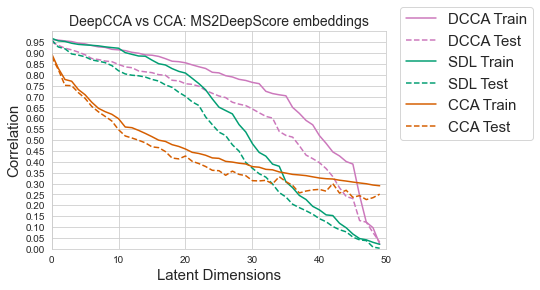

In [107]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                  'SDL Train', 'SDL Test',\
                  'CCA Train', 'CCA Test'], \
                   loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [18]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    # you might want to sort preds and return only top hits for better memory
    return preds
    

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [20]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [243]:
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,random_=False):
    tanimotos = []
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        
        #select top 5 hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:100] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
                if random_:#test with random: picks random subject index
                    
                    random_value = random.sample(values,1)
                    subject_index = values.index(random_value)
                    
                    smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                    smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                    top_hits_scores.append(tanimoto(smile1,smile2))
                
                else:# picks true hits index
                    subject_index = values.index(hit)
                    
                    smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                    smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                    top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
        #select closest 5 hits for each query based on cosine/euclidian distance
        else:
            top_hits = np.sort(values)[:100] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
                if random_:#test with random: picks random subject index
                    
                    random_value = random.sample(values,1)
                    subject_index = values.index(random_value)
                    
                    smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                    smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                    top_hits_scores.append(tanimoto(smile1,smile2))
                
                else:# picks true hits index
                    subject_index = values.index(hit)
                    
                    smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                    smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                    top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores)) # rank based on tanimoto return the index of the 5 hits based on tanis
    return tanimotos
    

In [237]:
%%time
#predict euc
test_dcca_corr = predict(subject_df=train_df,\
                        query_df=val_df.head(50),dims=50,\
                        method='sdl', metric='euc')

Wall time: 4.53 s


In [238]:
test_cca_corr = predict(subject_df=train_df,\
                       query_df=val_df.head(50),dims=50,\
                       method='cca',metric='euc')

In [194]:
# %%time
# #predict euc
# test_dcca_euc =  predict(subject_df=train_df,\
#                         query_df=test_df.head(50),dims=50,\
#                         method='dcca', metric='corr')

In [195]:
len(test_cca_corr.keys())

50

In [244]:
%%time
#calculate  Validation tanimotos 
    
    
test_dcca_corr_tanimotos = get_tanimotos(test_dcca_corr, \
                                       subject_df=train_df,\
                                        query_df=val_df.head(50),\
                                        metric='euc')

Wall time: 22 s


In [245]:
%%time
#calculate  Validation Euclidean tanimotos 
    
    
test_cca_corr_tanimotos = get_tanimotos(test_cca_corr, \
                                       subject_df=train_df,\
                                       query_df=val_df.head(50), \
                                       metric='euc')

Wall time: 19.6 s


In [241]:
random_tanimoto = get_tanimotos(test_dcca_corr, \
                                       subject_df=train_df,\
                                       query_df=val_df.head(50), \
                                       metric='cos', random_=True)

ValueError: [5.594825267791748] is not in list

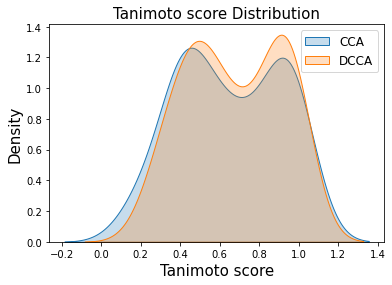

In [246]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [test_cca_corr_tanimotos,
             test_dcca_corr_tanimotos,
            #random_tanimoto
            ]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=True)
plt.legend(labels=['CCA',
                   'DCCA', 
                   #'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.show()

#### Draw Random predicted molecule

In [225]:
from rdkit import Chem
from rdkit.Chem import Draw

In [227]:
#randomly pick a query
keys = random.sample(test_dcca_corr.keys(),5)
sample_dict = {key: test_dcca_corr[key] for key in keys}

#draw select top 5 hits
all_mols = []
#scores = []
mol_classes = []
#os.chdir('../compounds')
for query_index, values in tqdm(sample_dict.items()):
    top_hits = np.sort(values)[:5]
    tanimotos = []
    
    #draw the query
    
    query_smile= val_df['smiles'].iloc[query_index]
    query_class = val_df['cf_class'].iloc[query_index]
    if type(query_class) == float:
        query_class = 'NAN'
        classes = [f'Query:\t{query_class}',]
    classes = [f'QUERY:\t{query_class}',]
    query = Chem.MolFromSmiles(query_smile)
    #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
    #Draw.MolsToGridImage(query)
    #draw top 5 hits
    subjects = [query,]
    for hit_index, hit in enumerate(top_hits):
        subject_index = values.index(hit)
        subject_smile = train_df['smiles'].iloc[subject_index]
        
        
        subject = Chem.MolFromSmiles(subject_smile)
        subjects.append(subject)
        #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
        cl = train_df['cf_class'].iloc[subject_index]
        if type(cl) == float:
            cl = 'NAN'
            subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
            classes.append(subject_class)
        else:
            subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
            classes.append(subject_class)
        #check tanimotos for the random selections
        tanimotos.append(tanimoto(query_smile,subject_smile))
   # scores.append([(query_index,query_class),tanimotos])
    all_mols.append(subjects)
    mol_classes.append(classes)


C:\Users\lmeli\AppData\Local\Temp/ipykernel_18484/2344889138.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(test_dcca_corr.keys(),5)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.03it/s]


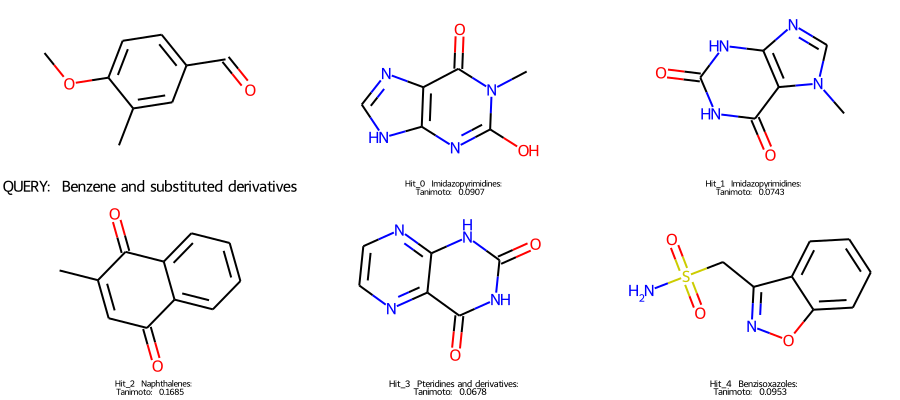

In [235]:
#draw the molecule
query=2
Draw.MolsToGridImage([all_mols[query][i] for i in range(len(all_mols[query]))],
                         molsPerRow=3, 
                     legends = mol_classes[query],
                    subImgSize=(300,200))


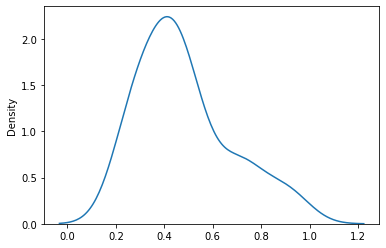

In [231]:
#just to see the highest corr attained
corr = []
for query_index, values in test_dcca_corr.items():
    corr.append(min(values))
    
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])